# whale back challenge, data wrangling, tensorflow models

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 18px; }</style>"))

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os
from skimage import io, transform
import skimage
import glob
from tqdm import tnrange, tqdm
from collections import Counter
from random import shuffle

%matplotlib inline

In [3]:
# some prep steps
data_folder = os.getcwd() + "/data/"
labels = pd.read_csv(data_folder+"train.csv")
train_folder = data_folder + "train/"
gray_train_folder = data_folder + "train_100x100_gray/"
test_folder = data_folder + "test/"
gray_test_folder = data_folder + "test_100x100_gray/"
images_glob_pattern = os.path.join(train_folder, '*.jpg')
glob_list = glob.glob(images_glob_pattern)
gray_glob_pattern = os.path.join(gray_train_folder, '*.jpg')
gray_glob_list = glob.glob(gray_glob_pattern)

image before preprocessing:
shape:  (700, 1050, 3)


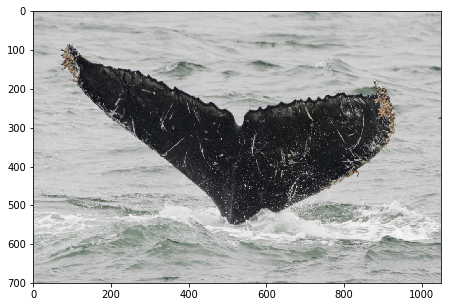

image after preprocessing: 
shape:  (100, 100)


/home/beno/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


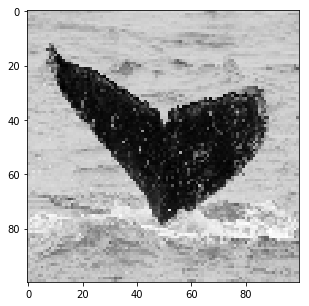

In [4]:
#display one original image, preprocess it and display it again
random_index = round(np.random.rand()*len(glob_list))
test_image = io.imread(glob_list[random_index])
print("image before preprocessing:")
print("shape: ",test_image.shape)
plt.figure(figsize=(10,5))
plt.imshow(test_image)
plt.show()
gray_image = io.imread(glob_list[random_index], as_gray=True)
gray_image = transform.resize(gray_image, (100,100), mode="reflect").astype(np.float)
print("image after preprocessing: ")
print("shape: ", gray_image.shape)
plt.figure(figsize=(10,5))
plt.imshow(gray_image, cmap="gray")
plt.show()

In [79]:
np.unique(labels).shape

(5005,)

In [83]:
Counter(labels).most_common()

AttributeError: 'list' object has no attribute 'revert'

In [5]:
#print all pictures for one whale for first impression.
test_set = labels[labels["Id"]=="w_bfe77d0"]
#for image_id in test_set["Image"]:
#    cur_image = io.imread("data/train_100x100_gray/" + image_id)
#    plt.figure(figsize=(10,5))
#    plt.imshow(cur_image)
#    plt.show()


In [6]:
# load every picture as grayscale image, reshape then save to other folder
#for image in tqdm(glob_list):
#    gray_image = io.imread(image, as_gray=True)
#    gray_image = transform.resize(gray_image, (100,100), mode="reflect").astype(np.float)
#    io.imsave(gray_train_folder + image[-13:], gray_image)

In [7]:
# load pictures and labels in two numpy arrays
tensor_list = []
idx = 0
for image in tqdm(gray_glob_list):
    cur_image = io.imread(image, as_gray=True)
    image_id = image[-13:]
    whale_id = labels[labels["Image"]==image_id]["Id"].values[0]
    tensor_list.append([whale_id, cur_image])
        
tensor_list = list(map(list, zip(*tensor_list)))
labels = np.array(tensor_list[0])
features = np.array(tensor_list[1])

100%|██████████| 25361/25361 [00:41<00:00, 613.83it/s]


In [39]:
# save data in .npz-file
#np.savez(data_folder + "gray_image_data", labels=labels, features=features)

In [12]:
#load .npz-file from folder
loader = np.load(data_folder+"gray_image_data.npz")
features = loader["features"]
labels = loader["labels"]

In [70]:
# train_test_split
train_ratio = 0.8
data = list(zip(list(features), list(labels)))
shuffle(data)
train_data = data[:int(train_ratio*len(data))]
val_data = data[int(train_ratio*len(data)):]
train_features = np.array([train_data[i][0] for i in range(len(train_data))])
train_labels = np.array([train_data[i][1] for i in range(len(train_data))])
val_features = np.array([val_data[i][0] for i in range(len(val_data))])
val_labels = np.array([val_data[i][0] for i in range(len(val_data))])

[array([[ 27,   1,  17, ...,  13,  13,  15],
        [  2,  15,  29, ...,   5,   9,  11],
        [ 18,  23,  11, ...,  11,  20,  25],
        ...,
        [253, 253, 253, ..., 253, 253, 253],
        [253, 253, 253, ..., 253, 253, 253],
        [253, 253, 253, ..., 253, 253, 253]], dtype=uint8),
 array([[ 51,  44,  88, ...,  38,  37,  45],
        [ 61,  60,  89, ...,  59,  52,  54],
        [120, 100, 105, ...,  64,  59,  62],
        ...,
        [ 67,  53,  46, ...,  54,  57,  53],
        [ 59,  52,  49, ...,  52,  56,  54],
        [ 50,  51,  48, ...,  52,  58,  56]], dtype=uint8),
 array([[123, 154, 184, ..., 136, 142, 127],
        [174, 181, 178, ..., 135, 149, 135],
        [189, 193, 185, ..., 120, 123,  97],
        ...,
        [212, 251, 253, ..., 169,  67,  93],
        [245, 242, 245, ..., 150,  94,  94],
        [254, 204, 205, ..., 181, 176, 110]], dtype=uint8),
 array([[217, 217, 217, ..., 218, 218, 218],
        [217, 217, 217, ..., 218, 218, 218],
        [217, 21

In [40]:
dataset = tf.data.Dataset.from_tensor_slices({"feature": features, "label": labels})
dataset.shuffle(30000)
train_data

In [41]:
dataset.output_types

{'feature': tf.uint8, 'label': tf.string}

In [31]:
#build batches
batch_size = 500
train_data.shuffle(30000)
batches = dataset.batch(batch_size)

In [28]:
labels.shape

(25361,)

In [29]:
batches

<BatchDataset shapes: {feature: (?, 100, 100), label: (?,)}, types: {feature: tf.uint8, label: tf.string}>

In [38]:


sess = tf.Session()
iterator = batches.make_one_shot_iterator()
next_element = iterator.get_next()
no_of_batches = int(np.ceil(labels.shape[0] / batch_size))
counter = 1
for i in tqdm(range(no_of_batches)):
    value = sess.run(next_element)
    print(value["feature"].shape)
    print(counter)
    counter+=1

sess.close()

100%|██████████| 51/51 [00:01<00:00, 34.34it/s]

(500, 100, 100)
1
(500, 100, 100)
2
(500, 100, 100)
3
(500, 100, 100)
4
(500, 100, 100)
5
(500, 100, 100)
6
(500, 100, 100)
7
(500, 100, 100)
8
(500, 100, 100)
9
(500, 100, 100)
10
(500, 100, 100)
11
(500, 100, 100)
12
(500, 100, 100)
13
(500, 100, 100)
14
(500, 100, 100)
15
(500, 100, 100)
16
(500, 100, 100)
17
(500, 100, 100)
18
(500, 100, 100)
19
(500, 100, 100)
20
(500, 100, 100)
21
(500, 100, 100)
22
(500, 100, 100)
23
(500, 100, 100)
24
(500, 100, 100)
25
(500, 100, 100)
26
(500, 100, 100)
27
(500, 100, 100)
28
(500, 100, 100)
29
(500, 100, 100)
30
(500, 100, 100)
31
(500, 100, 100)
32
(500, 100, 100)
33
(500, 100, 100)
34
(500, 100, 100)
35
(500, 100, 100)
36
(500, 100, 100)
37
(500, 100, 100)
38
(500, 100, 100)
39
(500, 100, 100)
40
(500, 100, 100)
41
(500, 100, 100)
42
(500, 100, 100)
43
(500, 100, 100)
44
(500, 100, 100)
45
(500, 100, 100)
46
(500, 100, 100)
47
(500, 100, 100)
48
(500, 100, 100)
49
(500, 100, 100)
50
(361, 100, 100)
51


In [22]:
sess.close()

In [ ]:
def batch_data(num_data, batch_size):   
    data_ixs = np.random.permutation(np.arange(num_data))
    ix = 0
    while ix + batch_size < num_data:
        batch_ixs = data_ixs[ix:ix+batch_size]
        ix += batch_size
        yield batch_ixs

In [29]:
counter = Counter(labels["Id"])
counter.most_common()

[('new_whale', 9664),
 ('w_23a388d', 73),
 ('w_9b5109b', 65),
 ('w_9c506f6', 62),
 ('w_0369a5c', 61),
 ('w_700ebb4', 57),
 ('w_3de579a', 54),
 ('w_564a34b', 51),
 ('w_fd3e556', 50),
 ('w_88e4537', 49),
 ('w_2b069ba', 48),
 ('w_d405854', 47),
 ('w_f0fe284', 45),
 ('w_789c969', 45),
 ('w_778e474', 40),
 ('w_5e8e218', 40),
 ('w_343f088', 40),
 ('w_a9304b9', 37),
 ('w_60ce6fc', 37),
 ('w_5a2634c', 37),
 ('w_6822dbc', 36),
 ('w_af367c3', 35),
 ('w_1ca9ab1', 34),
 ('w_f765256', 34),
 ('w_17b0d3a', 33),
 ('w_d72771c', 32),
 ('w_08630fd', 31),
 ('w_6cda039', 31),
 ('w_8c25681', 31),
 ('w_04003e9', 30),
 ('w_fd6a3ad', 30),
 ('w_51fc1fc', 30),
 ('w_2365d55', 29),
 ('w_59052ad', 29),
 ('w_6caff0f', 27),
 ('w_91cc02c', 25),
 ('w_bfcad53', 25),
 ('w_0a155b9', 24),
 ('w_b9e5911', 24),
 ('w_27597ff', 24),
 ('w_990921b', 24),
 ('w_cd4cb49', 24),
 ('w_75f6ffa', 24),
 ('w_0bc078c', 24),
 ('w_0135f5f', 23),
 ('w_5773c71', 23),
 ('w_e1ffbe2', 23),
 ('w_242fb46', 23),
 ('w_488865e', 22),
 ('w_8da30ad', 22)

https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right
create flipped images of underrepresented classes

In [11]:
# Normalize (between [0,1])? or standardize(mean=0, std=1)? for cnn data
def standardize(train, test):
    train = train.astype(np.float32)
    test = test.astype(np.float32)
    # Standardize train and test
    X_train = (train - np.mean(train, axis=0)[None,:]) / np.std(train, axis=0)[None,:]
    X_test = (test - np.mean(test, axis=0)[None,:]) / np.std(test, axis=0)[None,:]

    return X_train, X_test

In [12]:
train_data, val_data = standardize(train_data, val_data)

In [13]:
print(test_data.shape)
print(val_data.shape)

(1607, 120)
(1606, 120)


The skeleton of the class ```FeedForwardNet``` is provided in the following. This class implements a feed-forward neural network in Tensorflow. 
**Your task** is to complete the parts where it says ```### YOUR CODE HERE ###```. 

To complete the code properly, make sure that you make the computation graph based on the placeholders ```self.X``` and ```self.Y```. These two placeholders are created in the `build` function; you don't need to create them. You only need to use them.
* ```self.X```: a placeholder of shape ```[None,D]``` where the none dimension will be replaced by the number of instances, and $D$ is number of features.
* ```self.Y```: a placeholder of shape ```[None,K]``` where the none dimension will be replaced by the number of instances, and $K$ is number of classes.



In [51]:
class FeedForwardNet:
    """
    Simple feed forward neural network class
    """
    
    def __init__(self, hidden_sizes, layer_types, name, learning_rate=0.001, l2_reg=0.0):
        """ FeedForwardNet constructor.
        
        Parameters
        ----------
        hidden_sizes: list of ints
            The sizes of the hidden layers of the network.
        name: str
            The name of the network (used for a VariableScope)
        l2_reg: float
            The strength of L2 regularization (0 means no regularization)
        """
        
        self.hidden_sizes = hidden_sizes
        self.layer_types = layer_types
        self.name = name
        self.dropout = tf.placeholder_with_default(0.0, shape=(), name="dropout")
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg
        self.weights =[]
        self.biases =[]
    
    def build(self, data_dim, num_classes):
        """ Construct the model.
        
        Parameters
        ----------
        data_dim: int
            The dimensions of the data samples.

        Returns
        -------
        None

        """
        self.X = tf.placeholder(shape=[None, data_dim], dtype=tf.float32, name="data") #[NxD]
        self.Y = tf.placeholder(shape=[None, num_classes], dtype=tf.float32, name="labels") #[Nx1]
    
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
        
            hidden = self.X

            for ix, hidden_size in enumerate(self.hidden_sizes):
                W = tf.get_variable(f"{self.name}W{ix}", shape=[hidden.shape[1],hidden_size])
                b = tf.get_variable(f"{self.name}b{ix}", shape=[hidden_size])
                
                hidden = tf.nn.relu(hidden @ W + b)
                hidden = tf.nn.dropout(hidden, 1-self.dropout)
                
                self.weights.append(W)
                self.biases.append(b)
                    
            W_out = tf.get_variable(f"{self.name}W_out", shape=[hidden.shape[1],6])
            b_out = tf.get_variable(f"{self.name}b_out", shape=[6])
            
            self.weights.append(W_out)
            self.biases.append(b_out)
            
            self.logits = hidden @ W_out + b_out
            self.l2_norm = tf.add_n([tf.norm(w) for w in self.weights])
            self.cross_entropy_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.logits,labels=self.Y,name="cross_entropy_loss"))
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.logits > 0, tf.cast(self.Y, tf.bool)),tf.float32), name="accuracy")
            
            self.loss = self.cross_entropy_loss + self.l2_reg * self.l2_norm
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            self.opt_op = self.optimizer.minimize(self.loss, var_list=[*self.weights, *self.biases])
            
        
    def train(self, train_data, train_labels, val_data, val_labels, epochs=20, dropout=0.0, batch_size=512):
        """ Train the feed forward neural network.
        
        Parameters
        ----------
        train_data: np.array, dtype float32, shape [N, D]
            The training data. N corresponds to the number of training samples, D to the dimensionality of the data samples/
        train_labels: np.array, shape [N, K]
            The labels of the training data, where K is the number of classes.
        val_data: np.array, dtype float32, shape [N_val, D]
            The validation data. N_val corresponds to the number of validation samples, D to the dimensionality of the data samples/
        val_labels: np.array, shape [N_val, K]
            The labels of the training data, where K is the number of classes.
        epochs: int
            The number of epochs to train for.
        dropout: float
            The dropout rate used during training. 0 corresponds to no dropout.
        batch_size: int
            The batch size used for training.

        Returns
        -------
        None

        """
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []
        
        self.session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        session = self.session
        
        with session.as_default():
            session.run(tf.global_variables_initializer())
            
            tr_loss, tr_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: train_data, self.Y: train_labels})
            val_loss, val_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: val_data, self.Y: val_labels})
                
            train_losses.append(tr_loss)
            train_accs.append(tr_acc)
            
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            stopping_counter = 0
            
            for epoch in range(epochs):
                #if (epoch + 1) % 10 == 0:
                    #print(f"Epoch {epoch+1}/{epochs}")
                for batch_ixs in batch_data(len(train_data), batch_size):
                    _ = session.run([self.opt_op, self.loss], feed_dict={self.X: train_data[batch_ixs], self.Y: train_labels[batch_ixs]})
                    
                tr_loss, tr_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: train_data, self.Y: train_labels})
                val_loss, val_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: val_data, self.Y: val_labels})
                train_losses.append(tr_loss)
                train_accs.append(tr_acc)

                val_losses.append(val_loss)
                val_accs.append(val_acc)
                if epoch > 20:
                    if val_losses[-1] > np.mean(val_losses[-20:]):
                        stopping_counter += 1
                if stopping_counter > 4:
                    print(f"ending training due to stopping criterion after epoch {epoch}")
                    break

    
        self.hist={'train_loss': np.array(train_losses),
           'train_accuracy': np.array(train_accs),
           'val_loss': np.array(val_losses),
           'val_accuracy': np.array(val_accs), "epochs_trained": epoch}

In [5]:
#You can change layer types and the number of neurons by changing the following variables.
layer_types = [tf.nn.relu]
hidden_sizes = [64]
epochs = 20
batch_size = 512


model1 = FeedForwardNet(hidden_sizes, layer_types, "no_regularization")
model1.build(train_data.shape[1], num_classes=train_labels.shape[1])

model1.train(train_data, train_labels, val_data, val_labels, epochs,
                          batch_size=batch_size)

Epoch 25/250
Epoch 50/250
Epoch 75/250
Epoch 100/250
Epoch 125/250
Epoch 150/250
Epoch 175/250
Epoch 200/250
Epoch 225/250
Epoch 250/250


In [47]:
#You can change layer types and the number of neurons by changing the following variables.
layer_types = [tf.nn.relu, tf.nn.relu, tf.nn.relu]
hidden_sizes = [128, 64, 32, 16]
epochs = 250
batch_size = 256


model2 = FeedForwardNet(hidden_sizes, layer_types, "test_nn", learning_rate=0.001)
model2.build(train_data.shape[1], num_classes=train_labels.shape[1])

model2.train(train_data, train_labels, val_data, val_labels, epochs,
                          batch_size=batch_size, dropout=0.2)

Epoch 10/250
Epoch 20/250
Epoch 30/250
Epoch 40/250
ending training due to stopping criterion


#### Plot the training and validation losses over the epochs. What do you notice?

model 2


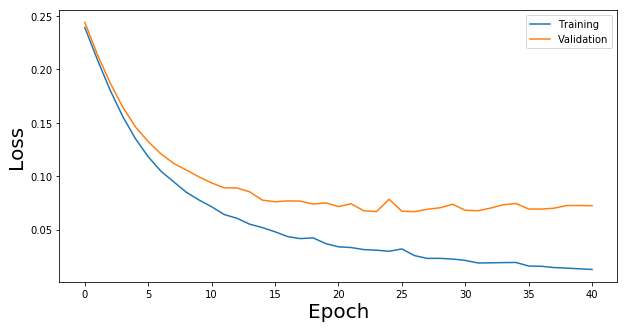

In [45]:
"""
print("model 1")
plt.figure(figsize=(10,5))
plt.plot(model1.hist['train_loss'][5::], label="Training")
plt.plot(model1.hist['val_loss'][5::], label="Validation")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()
"""
print("model 2")
plt.figure(figsize=(10,5))
plt.plot(model2.hist['train_loss'][5::], label="Training")
plt.plot(model2.hist['val_loss'][5::], label="Validation")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()

In [30]:
val_loss = model2.hist["val_loss"]

In [38]:
[val_loss[-k] > np.mean(val_loss[-k-20:-k]) for k in range(len(val_loss),21,-1)].index(True)

41

In [33]:
test = np.array(range(20))
np.mean(test[-5-5:-5])

12.0

#### Now plot the training and validation accuracies over the epochs.

model 1


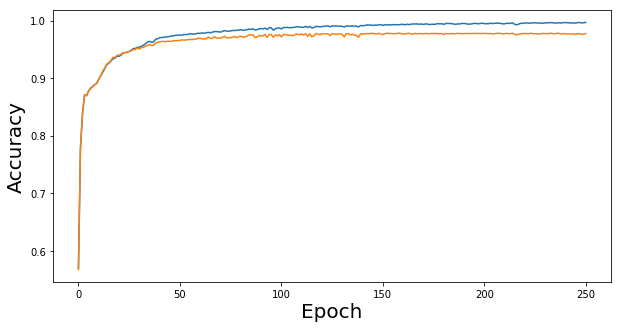

model 2


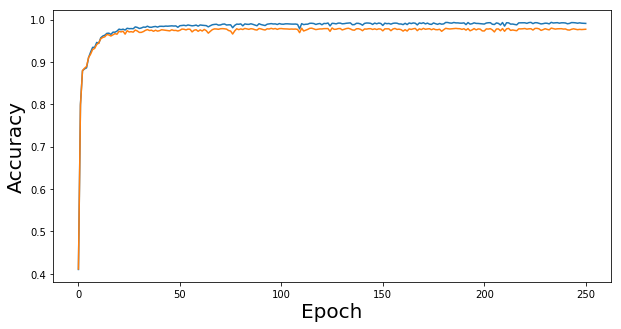

In [8]:
print("model 1")
plt.figure(figsize=(10,5))

plt.plot(model1.hist['train_accuracy'])
plt.plot(model1.hist['val_accuracy'])

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.show()

print("model 2")
plt.figure(figsize=(10,5))

plt.plot(model2.hist['train_accuracy'])
plt.plot(model2.hist['val_accuracy'])

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.show()

In [9]:
train_acc_1 = model1.hist['train_accuracy'][-1]
val_acc_1 = model1.hist['val_accuracy'][-1]

train_acc_2 = model2.hist['train_accuracy'][-1]
val_acc_2 = model2.hist['val_accuracy'][-1]

print(f"Training accuracy model 1: {train_acc_1:.3f}")
print(f"Validation accuracy model 1: {val_acc_1:.3f}")
print()

print(f"Training accuracy model 2: {train_acc_2:.3f}")
print(f"Validation accuracy model 2: {val_acc_2:.3f}")
print()

Training accuracy model 1: 0.997
Validation accuracy model 1: 0.978

Training accuracy model 2: 0.991
Validation accuracy model 2: 0.977



### Plot the losses and accuracies of the models in one plot to compare them.

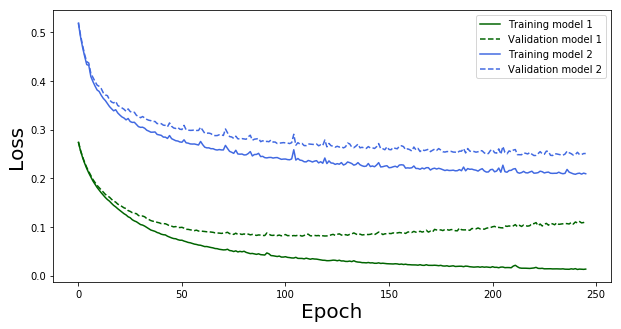

In [10]:
plt.figure(figsize=(10,5))
plt.plot(model1.hist['train_loss'][5::], label="Training model 1",
        color="darkgreen")
plt.plot(model1.hist['val_loss'][5::], label="Validation model 1",
        color="darkgreen", linestyle="--")

plt.plot(model2.hist['train_loss'][5::], label="Training model 2",
        color="royalblue")
plt.plot(model2.hist['val_loss'][5::], label="Validation model 2",
        color="royalblue", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()

## Comparing the models
Now, compare the final training and validation losses achieved by the different models.

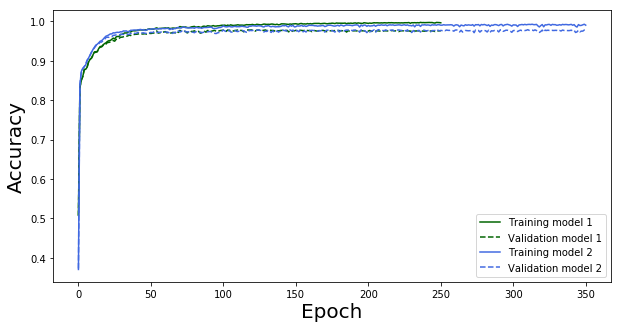

In [34]:
plt.figure(figsize=(10,5))

plt.plot(model1.hist['train_accuracy'], label="Training model 1",
        color="darkgreen")
plt.plot(model1.hist['val_accuracy'], label="Validation model 1",
        color="darkgreen", linestyle="--")

plt.plot(model2.hist['train_accuracy'], label="Training model 2",
        color="royalblue")
plt.plot(model2.hist['val_accuracy'], label="Validation model 2",
        color="royalblue", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

## Challenge

Notice that we also have the variable `test_data`. **Get creative** and build a model yourself!

Submit your predictions of the test data to Moodle to enter the leaderboard. We will announce the winning team after the Christmas break!

You can output the predictions of the test data using:

In [19]:
test_preds = NN_dropout_regularization.logits.eval({NN_dropout_regularization.X: test_data},
                                        session=NN_dropout_regularization.session).argmax(1)

We will only consider submission as plain text files with **exactly** the following formatting as our `sample_submission.txt`

In [20]:
string = ""
with open("sample_submission.txt", "r") as f:
    string = f.read()
print(string[:19])
print("...")

FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission.txt'

You can use the following command to save your predictions:

In [ ]:
np.savetxt("your_submission.txt", test_preds, fmt='%i')